### In this notebook we will learn:

* Getting Data: How to import data from PyCaret repository
* Setting up the sqlite database: To store the model artifacts, it is important to have a persistent database through sqlite.
* Setting up Environment: How to setup an experiment in PyCaret and get started with building classification models
* Create & Compare Models: How to create and compare various models, perform stratified cross validation and evaluate classification metrics
* Tune Model: How to automatically tune the hyper-parameters of a classification model
* Custom Tuning: How to manually change the searching strategy for hyperparameter tuning
* Ensemble Models: How to create ensemble of best performing models to improve the performance
* Plot Model: How to analyze model performance using various plots
* Finalize Model: How to finalize the best model at the end of the experiment
* Predict Model: How to make predictions on new / unseen data
* Save / Load Model: How to save / load a model for future use

## Loading Data 

### 1.1 Importing packages

In [1]:
# function
import os
import sys

new_directory = "E:/airflow/airflow"
current_directory = os.getcwd()
scripts_path = os.path.abspath(os.path.join(os.getcwd(), '../scripts'))

def change_directory(current_directory, new_directory,scripts_path):
    # Get the current working directory
    print(f'Current directory: {current_directory}')
    # Define the path to change to
    new_directory = "E:/airflow/airflow"
    try:
        # Change the current working directory
        os.chdir(new_directory)
        # Verify the change
        current_directory = os.getcwd()
        print(f'Current directory changed to: {current_directory}')
    except FileNotFoundError:
        print(f'Error: The directory "{new_directory}" does not exist.')
    except PermissionError:
        print(f'Error: Permission denied to change to "{new_directory}".')
    except Exception as e:
        print(f'An unexpected error occurred: {e}')
    # Add the scripts directory to the Python path
    sys.path.append(scripts_path)

    
change_directory(current_directory, new_directory, scripts_path)

Current directory: e:\airflow\airflow\notebooks
Current directory changed to: E:\airflow\airflow


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.utils import *
from pycaret.classification import *
# Other Libraries
import mlflow

In [3]:

# Setting up all directory
root_folder = "E:/airflow/airflow"
database_path = root_folder+"/database/"
data_directory = root_folder+"/data/raw/"
data_profile_path = root_folder+"/data/profile_report/"
intermediate_data_path = root_folder+"/data/interim/"
final_processed_data_path = root_folder+"/data/processed/"

old_data_directory = root_folder+"/data/raw/"
new_data_directory = root_folder+"/data/new/"
intermediate_path = root_folder+"/data/interim/"


# Database
db_path = root_folder+"/database/"
db_file_name = "feature_store_v01.db"
drfit_db_name = "drift_db_name.db"
date_columns = ['registration_init_time','transaction_date_min','transaction_date_max','membership_expire_date_max','last_login']
drift_db_name = "drift_db_name.db"

# Mlflow
mlflow_tracking_uri = "http://Localhost:6006"
ml_flow_model_path = root_folder+ "/mlruns/2/cb66e22bcbf74ded99dc219eb29e7609/artifacts/models/"
ml_flow_path = root_folder+ "/mlruns/2/cb66e22bcbf74ded99dc219eb29e7609"

run_on = "old" #"old"
append=False
date_transformation = False
start_date = '2017-03-01'
end_date = '2017-03-31'


 ### 1.2 Reading Data

In [4]:
%%time
final_data = "final_train_data_process_1729853409.csv" # set the data recieved from the previous notebook
dataset = load_data( [f"{final_processed_data_path}{final_data}",
                            ]
                         )[0] #since we are only loading single data, we can access it with index 0, since it return multiple dfs in list
dataset.shape

CPU times: total: 1.56 s
Wall time: 2.49 s


(324000, 38)

In [6]:
dataset.head()

,msno,city,bd,gender,registered_via,registration_init_time,is_churn,total_payment_channels,change_in_payment_methods,payment_plan_days_mean,...,num_50,num_75,num_985,num_100,num_unq,total_secs,date,login_freq,last_login,registration_duration
0,/7XuYVGXYHPggWsdtok0JEurQ10CtUO1Y8dDgy1/B0M=,1,6.3,2,7,2016-12-23,0,3,1,30.0,...,0.000000,0.0,0.000000,2.289867,2.289867,7.808594,2017-02-12 12:00:00.000000000,4,2017-02-14,89
1,gB3/kawEQSauWFArU9Z0kZo+ikw9GqJv0rXqNbpVnTY=,1,6.3,2,7,2016-12-23,0,3,1,30.0,...,0.000000,0.0,0.000000,2.845647,2.281930,8.363281,2017-02-19 12:00:00.000000000,4,2017-02-22,90
2,2aFAPs3QmxD+bNcCe8beuWcI7SZHg1k+1irALOxiw3k=,15,23.0,1,4,2016-12-24,0,3,1,30.0,...,0.000000,0.0,0.000000,4.708342,4.683700,10.236328,2017-01-14 12:00:00.000000000,4,2017-01-16,92
3,FjEZAhwFky8sWoaNGTp+p/r3/hH30WxLr396iSho3gs=,1,6.3,2,7,2016-12-25,0,3,1,30.0,...,0.173287,0.0,0.346574,3.070758,2.640511,8.630859,2017-02-18 12:00:00.000000000,4,2017-02-20,89
4,C5PNTuQxUQmHOXPptQnokhqH1XQoAHHL8pMWIX0nAh0=,1,6.3,2,7,2016-12-25,0,3,1,30.0,...,0.000000,0.0,0.000000,1.595831,1.499937,7.083334,2017-02-05 00:00:00.000000000,3,2017-02-09,89


 ### 1.3 Splitting the data to seen and unseen
 

In [7]:
data_for_model, data_unseen = get_validation_unseen_set(dataset, validation_frac=0.05, sample=True, sample_frac=0.1)
print('Data for Modeling: ' + str(data_for_model.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (30780, 38)
Unseen Data For Predictions: (1620, 38)


### 2 Setting up the sqlite database

In [8]:
create_sqlit_connection(database_path,r"mlflow_v01.db")

2.6.0


import subprocess

subprocess.run([
    'mlflow', 'server',
    '--backend-store-uri', 'sqlite://///home/charliethomasctg/airflow/database/mlflow_v01.db',
    '--default-artifact-root', '/home/charliethomasctg/airflow/mlruns',
    '--port=6006',
    '--host=0.0.0.0'
])


### 3 Setting up Environment: 

In [9]:
mlflow.set_tracking_uri(mlflow_tracking_uri)


In [11]:
# Convert to datetime
for col in date_columns:
    data_for_model[col] = pd.to_datetime(data_for_model[col])

In [12]:
#run this on terminal 
#MAKE mlrun FOLDER
#mlflow server --backend-store-uri='sqlite:///mlflow_v01.db' --default-artifact-root="mlruns/" --port=6006 --host=0.0.0.0

In [14]:
exp_clf102 = setup(data=data_for_model, target='is_churn',
                   fold_shuffle=True,
                   session_id=42,
                   fix_imbalance=True,
                   ignore_features=['msno'], 
                   normalize=True,
                   #transformation=True,
                   #ignore_low_variance=True,
                   remove_multicollinearity=True,
                   multicollinearity_threshold=0.95,
                   date_features=['registration_init_time', 'transaction_date_min',
                                  'transaction_date_max', 'membership_expire_date_max', 'last_login'],
                   n_jobs=-1,
                   use_gpu=True,
                   log_experiment=True,
                   experiment_name='model_exp02',
                   log_plots=True,
                   log_data=True,
                   verbose=True,
                   log_profile=False)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leav

,Description,Value
0,Session id,42
1,Target,is_churn
2,Target type,Binary
3,Original data shape,"(30780, 38)"
4,Transformed data shape,"(49336, 44)"
5,Transformed train set shape,"(40102, 44)"
6,Transformed test set shape,"(9234, 44)"
7,Ignore features,1
8,Numeric features,30
9,Date features,5


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leav

### 4 Compare models: 

In [15]:
best_model = compare_models(fold = 5,include=['lightgbm','rf','et','lr'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9483,0.9580,0.4114,0.7272,0.5243,0.4991,0.5225,1.3240
rf,Random Forest Classifier,0.9397,0.9430,0.3391,0.6212,0.4379,0.4090,0.4304,2.0020
lightgbm,Light Gradient Boosting Machine,0.9299,0.7849,0.3699,0.4963,0.4230,0.3865,0.3917,2.7660
lr,Logistic Regression,0.9266,0.9256,0.3933,0.4683,0.4270,0.3882,0.3901,0.6880


2024/10/25 11:58:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/25 11:58:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Extra Trees Classifier at: http://Localhost:6006/#/experiments/4/runs/6a39a030692c4b5e9b4b47ddb4a2a5ca.
2024/10/25 11:58:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://Localhost:6006/#/experiments/4.
2024/10/25 11:58:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/25 11:58:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest Classifier at: http://Localhost:6006/#/experiments/4/runs/81f130ae671f4c5ca483b5d407ed8e75.
2024/10/25 11:58:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://Localhost:6006/#/e

### 4.1 Create a Model

In [16]:
#selecting the LGBM considering overall performance
lgbm  = create_model('lightgbm', fold = 5) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9334,0.7875,0.3846,0.5275,0.4449,0.4104,0.4162
1,0.9308,0.7839,0.3411,0.5025,0.4064,0.3711,0.3789
2,0.9355,0.7880,0.3712,0.5522,0.4440,0.4111,0.4203
3,0.9199,0.7624,0.3478,0.4094,0.3761,0.3337,0.3349
4,0.9315,0.7751,0.4147,0.5082,0.4567,0.4206,0.4231
Mean,0.9302,0.7794,0.3719,0.5000,0.4256,0.3894,0.3947
Std,0.0054,0.0097,0.0265,0.0485,0.0300,0.0326,0.0339


2024/10/25 12:01:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/25 12:01:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run Light Gradient Boosting Machine at: http://Localhost:6006/#/experiments/4/runs/431f33c621154173919864adf319cf1a.
2024/10/25 12:01:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://Localhost:6006/#/experiments/4.


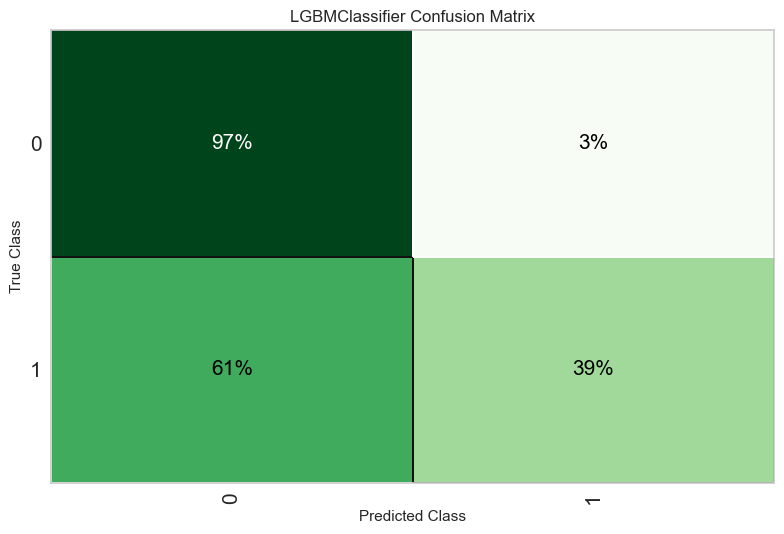

In [17]:
plot_model(lgbm, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

### 5 Tuning the Models
When a model is created using the `create_model()` function it uses the default hyperparameters. In order to tune hyperparameters, the `tune_model()` function is used. This function automatically tunes the hyperparameters of a model on a pre-defined search space and scores it using stratified cross validation. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1 and Kappa by fold.

> Note: `tune_model()` does not take a trained model object as an input. It instead requires a model name to be passed as an abbreviated string similar to how it is passed in `create_model()`. All other functions in pycaret.classification require a trained model object as an argument.

In [18]:
tuned_lgbm, tuner_0 = tune_model(lgbm, 
                            fold = 5,
                            optimize = 'F1', 
                            choose_better = True, 
                            return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9418,0.9536,0.5819,0.5800,0.5810,0.5497,0.5497
1,0.9366,0.9506,0.6154,0.5380,0.5741,0.5400,0.5415
2,0.9390,0.9477,0.6288,0.5529,0.5884,0.5556,0.5569
3,0.9357,0.9470,0.6187,0.5316,0.5719,0.5373,0.5391
4,0.9274,0.9394,0.4281,0.4741,0.4499,0.4111,0.4117
Mean,0.9361,0.9477,0.5746,0.5353,0.5531,0.5188,0.5198
Std,0.0048,0.0048,0.0749,0.0349,0.0519,0.0542,0.0544


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 16040, number of negative: 16040
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7371
[LightGBM] [Info] Number of data points in the train set: 32080, number of used features: 42

2024/10/25 12:15:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/25 12:15:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run Light Gradient Boosting Machine at: http://Localhost:6006/#/experiments/4/runs/f04b0f409b404bd499da112183f27fc9.
2024/10/25 12:15:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://Localhost:6006/#/experiments/4.


### 5.1 Custom Tuning

While creating models using `create_model()` method, you can observe the model's cross validation training score. 

To observe, it you have set `return_train_score=True`, by default it is set to False
If False, returns the CV Validation scores only. If True, returns the CV training scores along with the CV validation scores. This is useful when the user wants to do bias-variance tradeoff. A high CV training score with a low corresponding CV validation score indicates overfitting.


We can change the searching strategy used for Hyperparameter tuning using the parameter `search_algorithm` 
* search_algorithm: str, default = None

The search algorithm depends on the `search_library` parameter. Some search algorithms require additional libraries to be installed. If None, will use search library-specific default algorithm.

> ‘scikit-learn’ possible values:
* ‘random’ : random grid search (default)
* ‘grid’ : grid search

> ‘scikit-optimize’ possible values:
* ‘bayesian’ : Bayesian search (default)

> ‘tune-sklearn’ possible values:
* ‘random’ : random grid search (default)
*  ‘grid’ : grid search
* ‘bayesian’ : pip install scikit-optimize
* ‘hyperopt’ : pip install hyperopt
* ‘optuna’ : pip install optuna
* ‘bohb’ : pip install hpbandster ConfigSpace

> ‘optuna’ possible values:
* ‘random’ : randomized search
* ‘tpe’ : Tree-structured Parzen Estimator search (default)

#### 5.1.1 Custom tuning using `Random-search`

In [19]:
tuned_lgbm_skopt,tuner_1 = tune_model(lgbm, 
                                   search_library = 'scikit-optimize',
                                   fold = 5 ,
                                   optimize = 'F1',
                                   choose_better = True, 
                                   return_tuner=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:15:17
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9552,0.9659,0.6990,0.6699,0.6841,0.6600,0.6602
1,0.9540,0.9636,0.7291,0.6507,0.6877,0.6630,0.6642
2,0.9527,0.9584,0.7291,0.6393,0.6812,0.6558,0.6575
3,0.9473,0.9607,0.6990,0.6040,0.6481,0.6198,0.6217
4,0.9376,0.9485,0.4314,0.5658,0.4896,0.4570,0.4617
Mean,0.9494,0.9594,0.6575,0.6259,0.6381,0.6111,0.6131
Std,0.0065,0.0060,0.1138,0.0369,0.0756,0.0786,0.0772


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] feature_fraction is set=0.9597207993087004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9597207993087004
[LightGBM] [Warning] bagging_fraction is set=0.6460623753119883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6460623753119883
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9597207993087004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9597207993087004
[LightGBM] [Warning] bagging_fraction is set=0.6460623753119883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6460623753119883
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 16040, number of negative: 16040
[LightGBM] [Info] This is the GPU trainer!!
[LightGB

2024/10/25 12:18:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/25 12:18:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run Light Gradient Boosting Machine at: http://Localhost:6006/#/experiments/4/runs/3c75247558594295b13b78c5d177b449.
2024/10/25 12:18:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://Localhost:6006/#/experiments/4.


In [20]:
tuned_lgbm_optuna,tuner_2 = tune_model(lgbm, 
                                    search_library='optuna',
                                    search_algorithm='random',
                                    fold = 5,
                                    optimize = 'F1',
                                    return_train_score=True,
                                    choose_better=True,
                                    return_tuner=True)

[LightGBM] [Warning] feature_fraction is set=0.4348501673009197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4348501673009197
[LightGBM] [Warning] bagging_fraction is set=0.9197056874649611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9197056874649611
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4348501673009197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4348501673009197
[LightGBM] [Warning] bagging_fraction is set=0.9197056874649611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9197056874649611
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16040, number of negative: 16040
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7371
[LightGBM] [Info] Number of data 

2024/10/25 12:23:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/25 12:23:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Light Gradient Boosting Machine at: http://Localhost:6006/#/experiments/4/runs/89d87ea5e739472d954cd84a105a506e.
2024/10/25 12:23:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://Localhost:6006/#/experiments/4.


### 6 Analyzing the model performance


6.1 Learning Curve

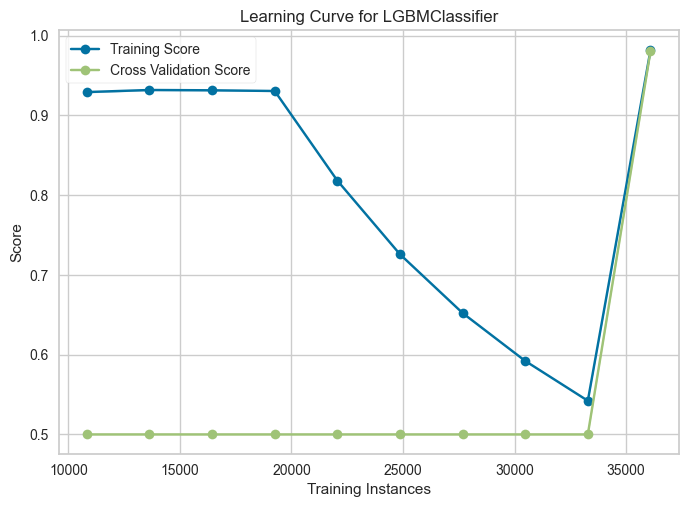

In [21]:
plot_model(tuned_lgbm_skopt, plot = 'learning')

6.2 AUC Curve

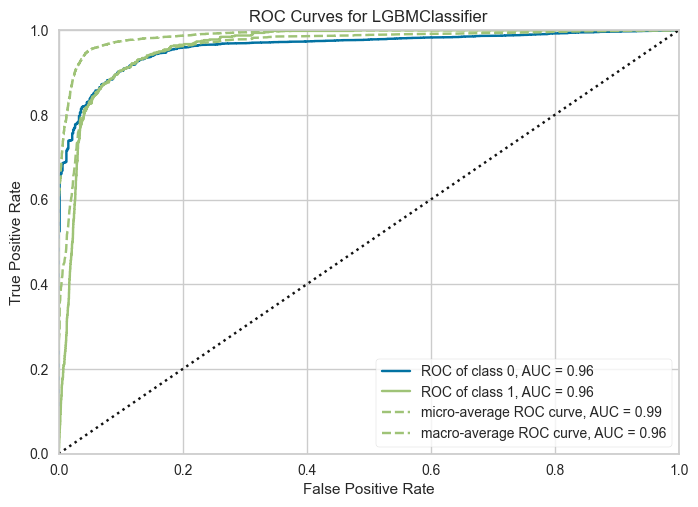

In [30]:
plot_model(tuned_lgbm_skopt, plot = 'auc')

6.3 Precision-recall Curve

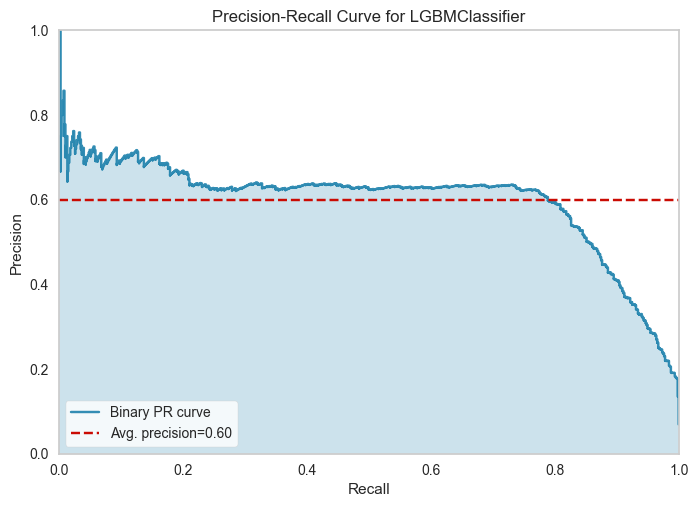

In [31]:
plot_model(tuned_lgbm_skopt, plot = 'pr')

6.4 Confusion Matrix

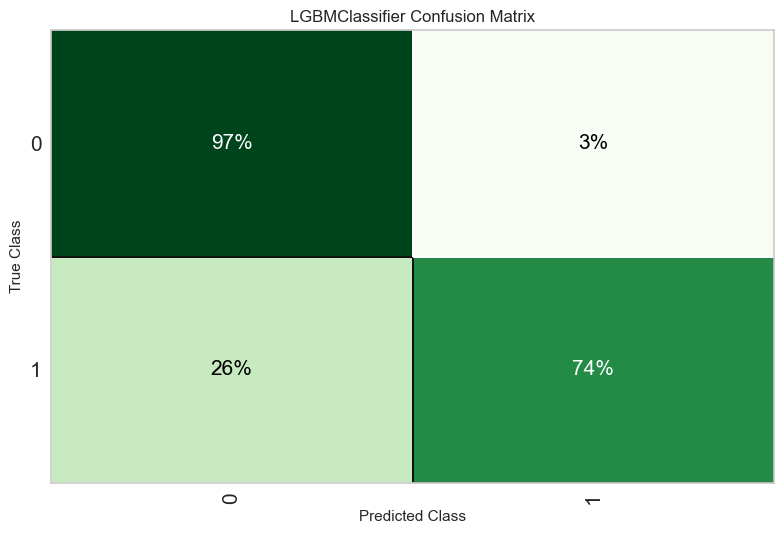

In [32]:
plot_model(tuned_lgbm_skopt, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

6.5 Feature Importance

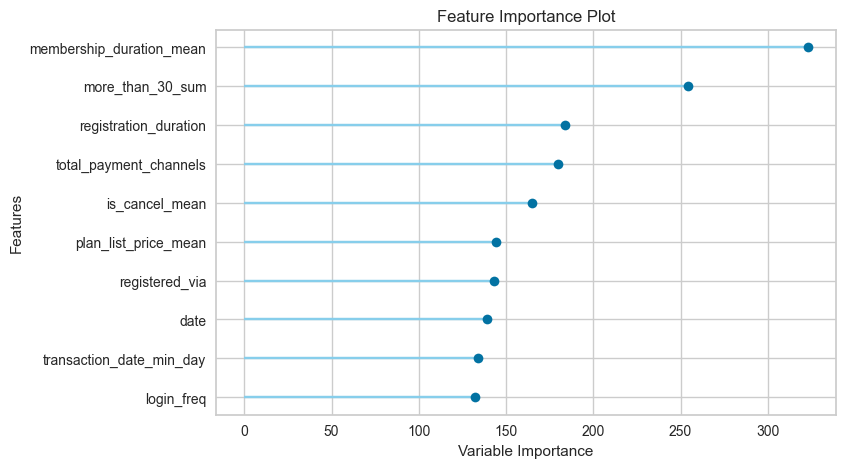

In [33]:
plot_model(tuned_lgbm_skopt, plot = 'feature')

6.6 Model Interpretaion

In [34]:
#pip install shap

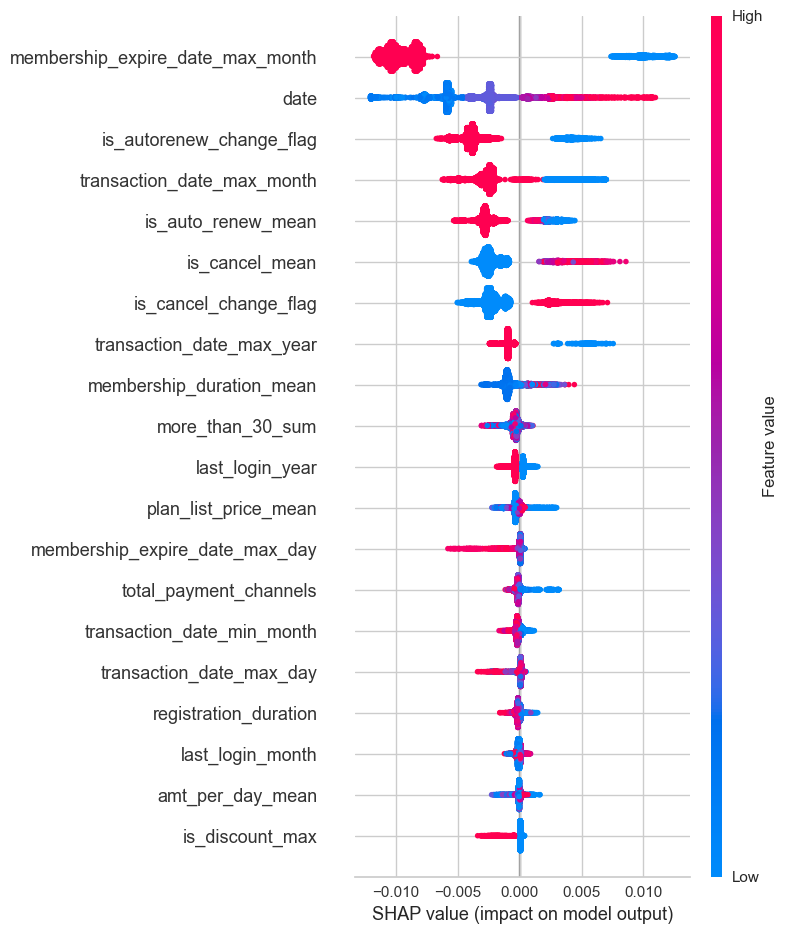

In [35]:
interpret_model(tuned_lgbm_skopt)

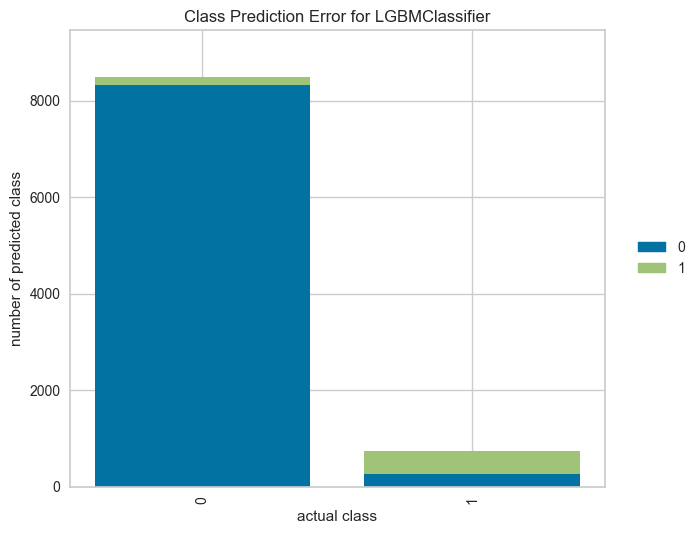

In [36]:
plot_model(tuned_lgbm_skopt, plot='error')

In [37]:
from pycaret.classification import interpret_model

interpret_model(tuned_lgbm_skopt, plot='shap', feature='bd')

import shap
shap_values = get_shap_values(tuned_lgbm_skopt)  # Get SHAP values for your model
print(shap_values.shape)  # Should show the shape of SHAP values


TypeError: can only concatenate list (not "str") to list

In [38]:
interpret_model(tuned_lgbm_skopt,plot='correlation',feature='registration_duration')

IndexError: index 42 is out of bounds for axis 1 with size 1

In [39]:
interpret_model(tuned_lgbm_skopt,plot='reason',observation=0) # index of observation in test data

IndexError: invalid index to scalar variable.

### 7 Evaluating the model

In [40]:
# Convert to datetime
for col in date_columns:
    data_unseen[col] = pd.to_datetime(data_unseen[col])
predict_model(lgbm, data_unseen)
predict_model(tuned_lgbm_optuna, data=data_unseen).head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9315,0.8033,0.4309,0.5638,0.4885,0.4525,0.4572


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9444,0.9556,0.6829,0.6222,0.6512,0.6211,0.6218


[LightGBM] [Warning] feature_fraction is set=0.5827682615040224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5827682615040224
[LightGBM] [Warning] bagging_fraction is set=0.45860326840383037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45860326840383037
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5827682615040224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5827682615040224
[LightGBM] [Warning] bagging_fraction is set=0.45860326840383037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45860326840383037
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


,msno,city,bd,gender,registered_via,registration_init_time,total_payment_channels,change_in_payment_methods,payment_plan_days_mean,change_in_plan,...,num_100,num_unq,total_secs,date,login_freq,last_login,registration_duration,is_churn,prediction_label,prediction_score
0,HSMmbnAlhaYg4jat/jB8q4Kd6lfk7iy5dcCSEN2XK6A=,1,6.3,2,7,2016-07-01,8,1,30.0,1,...,2.808750,2.094697,8.172526,2016-10-11 20:00:00.000000000,12,2017-01-14,273,0,0,0.5001
1,5Hld4xDT+htY/Qd5o8UkN/6ngD2fV4fOrBKN3I70QEY=,1,6.3,2,7,2015-11-27,16,1,30.0,1,...,1.736636,1.977096,7.425261,2016-07-10 20:48:00.000000000,15,2017-02-12,485,0,0,0.5001
2,tKiQu9ZKjhLasfLHi2q5dyv2CInji98RjnuKTsKh0o0=,1,6.3,2,7,2016-03-26,12,1,30.0,1,...,2.267421,2.295314,7.780762,2016-08-21 09:00:00.000000000,8,2016-12-14,364,0,0,0.5001
3,SVk+0afkNvPvkR8IJK4hcO1q1Nt9Hhlp8pBhZNPbGQ0=,1,6.3,2,7,2016-02-12,14,1,30.0,1,...,2.186713,2.432265,7.796224,2016-07-30 12:00:00.000000000,6,2017-02-14,393,1,0,0.5000
4,s0T9IasYAAsOmSmP/OaTCqmfHbu5MiPyMqPe+uQIuGc=,1,6.3,2,7,2015-10-14,19,1,30.0,1,...,2.252904,2.453055,7.825474,2016-05-29 06:00:00.000000000,28,2016-12-26,528,0,0,0.5001
